In [41]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import math
sns.set_theme(style='darkgrid')
import pylab as pl

In [42]:
pd.set_option("display.max_columns", None)

In [43]:
from data import get_data
from helpers import pred_to_perf

In [44]:
def fast_fracdiff(x, d):

    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [45]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8], sheet_name='features').fillna('ffill').shift(1).dropna()
data.to_csv('data/data.csv')
data.head()

,SPI,SMALL_MID,LARGE,MATERIALS,CONSUMER STAPLE,INDUSTRIALS,CONSUMER DIS.,HEALTH CARE,FINANCIALS,EURCHF,USDCHF,US 2YEAR,US 5YEAR,US 10YEAR,GOLD,SILVER,BRENT,SP500,RUSSELL 2000,SURPRISE
2006-01-05,5851.15,1508.31,5833.18,178.64,112.61,141.34,90.73,113.33,112.92,1.54730,1.2760,4.304,4.277,4.344,532.30,9.095,61.68,1273.46,689.271,24.4
2006-01-06,5837.78,1509.53,5818.60,176.64,111.82,140.49,90.35,113.58,112.54,1.54475,1.2772,4.321,4.284,4.354,526.80,8.755,61.13,1273.48,691.789,28.2
2006-01-09,5850.81,1516.33,5828.32,177.97,112.21,141.26,90.89,113.72,113.26,1.54178,1.2702,4.354,4.316,4.375,539.60,9.025,62.72,1285.45,699.404,25.3
2006-01-10,5849.79,1518.68,5823.36,178.12,112.13,141.31,91.39,113.75,113.49,1.54245,1.2769,4.345,4.302,4.367,547.80,9.175,62.01,1290.15,706.259,26.3
2006-01-11,5811.98,1512.24,5785.15,175.83,112.20,140.68,90.89,112.71,112.51,1.54515,1.2807,4.395,4.358,4.426,542.08,8.955,61.92,1289.69,711.010,26.4


In [46]:
data['MATERIALS'] *= data['EURCHF']
data['CONSUMER STAPLE'] *= data['EURCHF']
data['INDUSTRIALS'] *= data['EURCHF']
data['CONSUMER DIS.'] *= data['EURCHF']
data['HEALTH CARE'] *= data['EURCHF']
data['FINANCIALS'] *= data['EURCHF']
data['GOLD'] *= data['USDCHF']
data['SILVER'] *= data['USDCHF']
data['BRENT'] *= data['USDCHF']
data['SP500'] *= data['USDCHF']
data['RUSSELL 2000'] *= data['USDCHF']

data.head()

,SPI,SMALL_MID,LARGE,MATERIALS,CONSUMER STAPLE,INDUSTRIALS,CONSUMER DIS.,HEALTH CARE,FINANCIALS,EURCHF,USDCHF,US 2YEAR,US 5YEAR,US 10YEAR,GOLD,SILVER,BRENT,SP500,RUSSELL 2000,SURPRISE
2006-01-05,5851.15,1508.31,5833.18,276.409672,174.241453,218.695382,140.386529,175.355509,174.721116,1.54730,1.2760,4.304,4.277,4.344,679.214800,11.605220,78.703680,1624.934960,879.509796,24.4
2006-01-06,5837.78,1509.53,5818.60,272.864640,172.733945,217.021928,139.568162,175.452705,173.846165,1.54475,1.2772,4.321,4.284,4.354,672.828960,11.181886,78.075236,1626.488656,883.552911,28.2
2006-01-09,5850.81,1516.33,5828.32,274.390587,173.003134,217.791843,140.132384,175.331222,174.622003,1.54178,1.2702,4.354,4.316,4.375,685.399920,11.463555,79.666944,1632.778590,888.382961,25.3
2006-01-10,5849.79,1518.68,5823.36,274.741194,172.954918,217.963610,140.964506,175.453688,175.052650,1.54245,1.2769,4.345,4.302,4.367,699.485820,11.715558,79.180569,1647.392535,901.822117,26.3
2006-01-11,5811.98,1512.24,5785.15,271.683725,173.365830,217.371702,140.438683,174.153856,173.844827,1.54515,1.2807,4.395,4.358,4.426,694.241856,11.468668,79.300944,1651.705983,910.590507,26.4


In [47]:
target_prices = data[['SMALL_MID', 'LARGE']]
bench_price = data['SPI']
raw_features = data[data.columns.difference(['SPI', 'EURCHF', 'USDCHF'])]

In [48]:
mom5 = raw_features[raw_features.columns.difference(['SURPRISE'])].rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom5 = mom5.add_suffix(' mom5')

mom21 = raw_features[raw_features.columns.difference(['SURPRISE'])].rolling(21).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom21 = mom21.add_suffix(' mom21')

mom63 = raw_features[raw_features.columns.difference(['SURPRISE'])].rolling(63).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
mom63 = mom63.add_suffix(' mom63')

ema_12 = raw_features[raw_features.columns.difference(['SURPRISE'])].ewm(span=12).mean()
ema_26 = raw_features[raw_features.columns.difference(['SURPRISE'])].ewm(span=26).mean()
MACD = (ema_12 - ema_26) - (ema_12 - ema_26).ewm(span=9).mean()
MACD = MACD.add_suffix(' MACD')

raw_features['SURPRISE'] = fast_fracdiff(raw_features['SURPRISE'], 0.5)

features = pd.concat([mom5, mom21, mom63, MACD, raw_features['SURPRISE']], axis=1).ewm(5).mean().dropna()
features.head(1)

<ipython-input-48-d1cfe81dd137>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_features['SURPRISE'] = fast_fracdiff(raw_features['SURPRISE'], 0.5)


,BRENT mom5,CONSUMER DIS. mom5,CONSUMER STAPLE mom5,FINANCIALS mom5,GOLD mom5,HEALTH CARE mom5,INDUSTRIALS mom5,LARGE mom5,MATERIALS mom5,RUSSELL 2000 mom5,SILVER mom5,SMALL_MID mom5,SP500 mom5,US 10YEAR mom5,US 2YEAR mom5,US 5YEAR mom5,BRENT mom21,CONSUMER DIS. mom21,CONSUMER STAPLE mom21,FINANCIALS mom21,GOLD mom21,HEALTH CARE mom21,INDUSTRIALS mom21,LARGE mom21,MATERIALS mom21,RUSSELL 2000 mom21,SILVER mom21,SMALL_MID mom21,SP500 mom21,US 10YEAR mom21,US 2YEAR mom21,US 5YEAR mom21,BRENT mom63,CONSUMER DIS. mom63,CONSUMER STAPLE mom63,FINANCIALS mom63,GOLD mom63,HEALTH CARE mom63,INDUSTRIALS mom63,LARGE mom63,MATERIALS mom63,RUSSELL 2000 mom63,SILVER mom63,SMALL_MID mom63,SP500 mom63,US 10YEAR mom63,US 2YEAR mom63,US 5YEAR mom63,BRENT MACD,CONSUMER DIS. MACD,CONSUMER STAPLE MACD,FINANCIALS MACD,GOLD MACD,HEALTH CARE MACD,INDUSTRIALS MACD,LARGE MACD,MATERIALS MACD,RUSSELL 2000 MACD,SILVER MACD,SMALL_MID MACD,SP500 MACD,US 10YEAR MACD,US 2YEAR MACD,US 5YEAR MACD,SURPRISE
2006-04-03,0.004831,0.000693,-0.000726,0.000012,0.003677,-0.000045,0.001047,-0.000138,0.002142,0.002206,0.0075,0.001734,-0.000306,0.002904,0.00222,0.002804,0.001469,0.001651,0.000605,0.000916,0.000493,0.00206,0.001129,0.000582,0.00149,0.00107,0.004987,0.001987,0.00034,0.001733,0.000656,0.001236,0.0014,0.001239,0.00069,0.00157,0.001787,0.000537,0.001709,0.000648,0.001759,0.002005,0.004147,0.001972,0.000611,0.001746,0.001797,0.001871,0.291439,0.203785,-0.248027,-0.101876,1.674236,0.131107,0.039243,-2.128181,0.644076,1.476517,0.070159,1.788564,-0.247298,0.001574,0.001126,-0.001084,1.700167


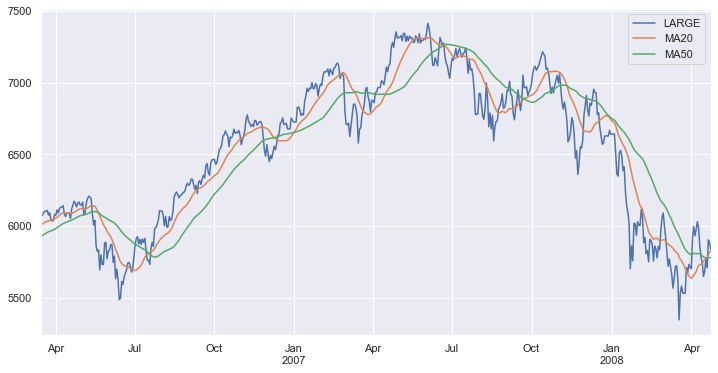

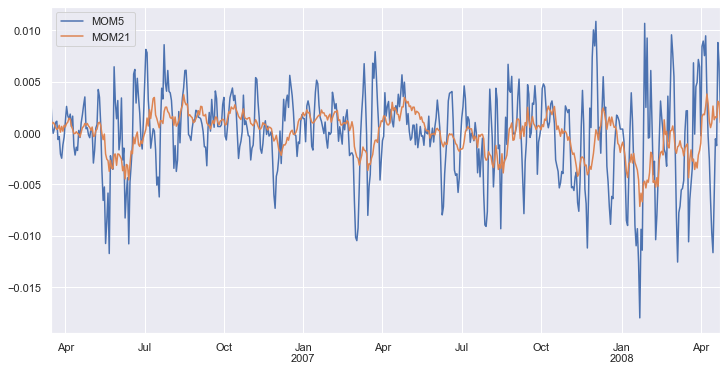

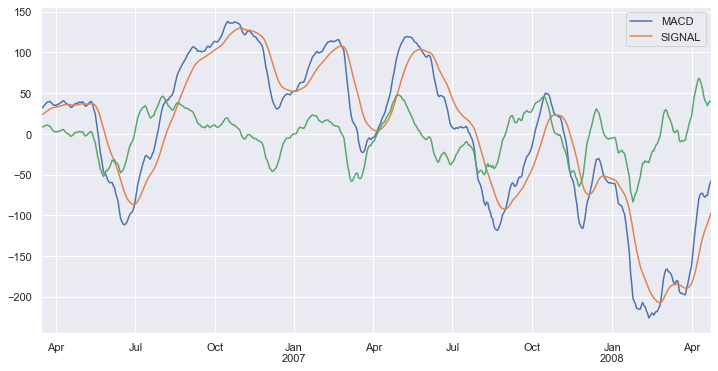

In [49]:
df = pd.DataFrame()
df['LARGE'] = target_prices.LARGE
df['MA20'] = df.LARGE.rolling(20).mean()
df['MA50'] = df.LARGE.rolling(50).mean()

df['EMA12'] = df.LARGE.ewm(12).mean()
df['EMA26'] = df.LARGE.ewm(26).mean()
df['MACD'] = df.EMA12 - df.EMA26
df['SIGNAL'] = df.MACD.ewm(9).mean()

df['MOM5'] = df.LARGE.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x))
df['MOM21'] = df.LARGE.rolling(21).apply(lambda x: np.log(x[-1] / x[0]) / len(x))


df = df.iloc[50:600]

fig, ax = plt.subplots(figsize=(12, 6))
df[['LARGE', 'MA20', 'MA50']].plot(ax=ax)

fig, ax = plt.subplots(figsize=(12, 6))
df[['MOM5', 'MOM21']].plot(ax=ax)

fig, ax = plt.subplots(figsize=(12, 6))
df[['MACD']].plot(ax=ax)
df[['SIGNAL']].plot(ax=ax)
(df['MACD'] - df['SIGNAL']).plot(ax=ax)

plt.show()

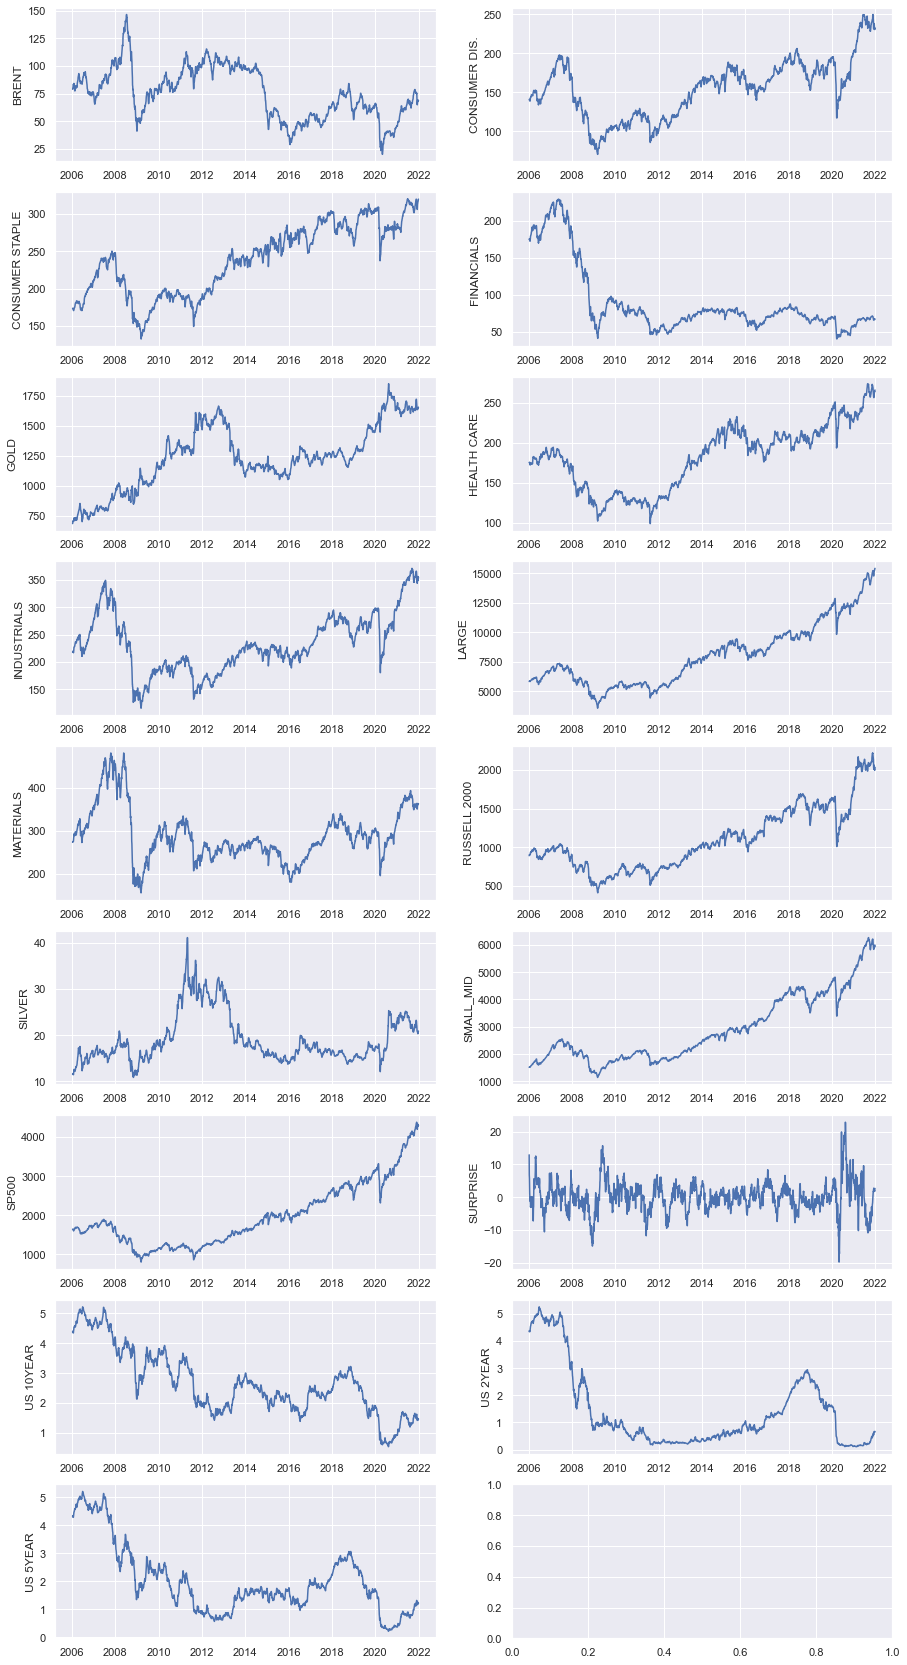

In [50]:
fig, axs = plt.subplots(math.ceil(len(raw_features.columns) / 2), 2, figsize=(15, 30))
axs = axs.ravel()
for i, raw_feature in enumerate(raw_features):
    sns.lineplot(ax=axs[i], data=raw_features[raw_feature].rolling(5).mean())

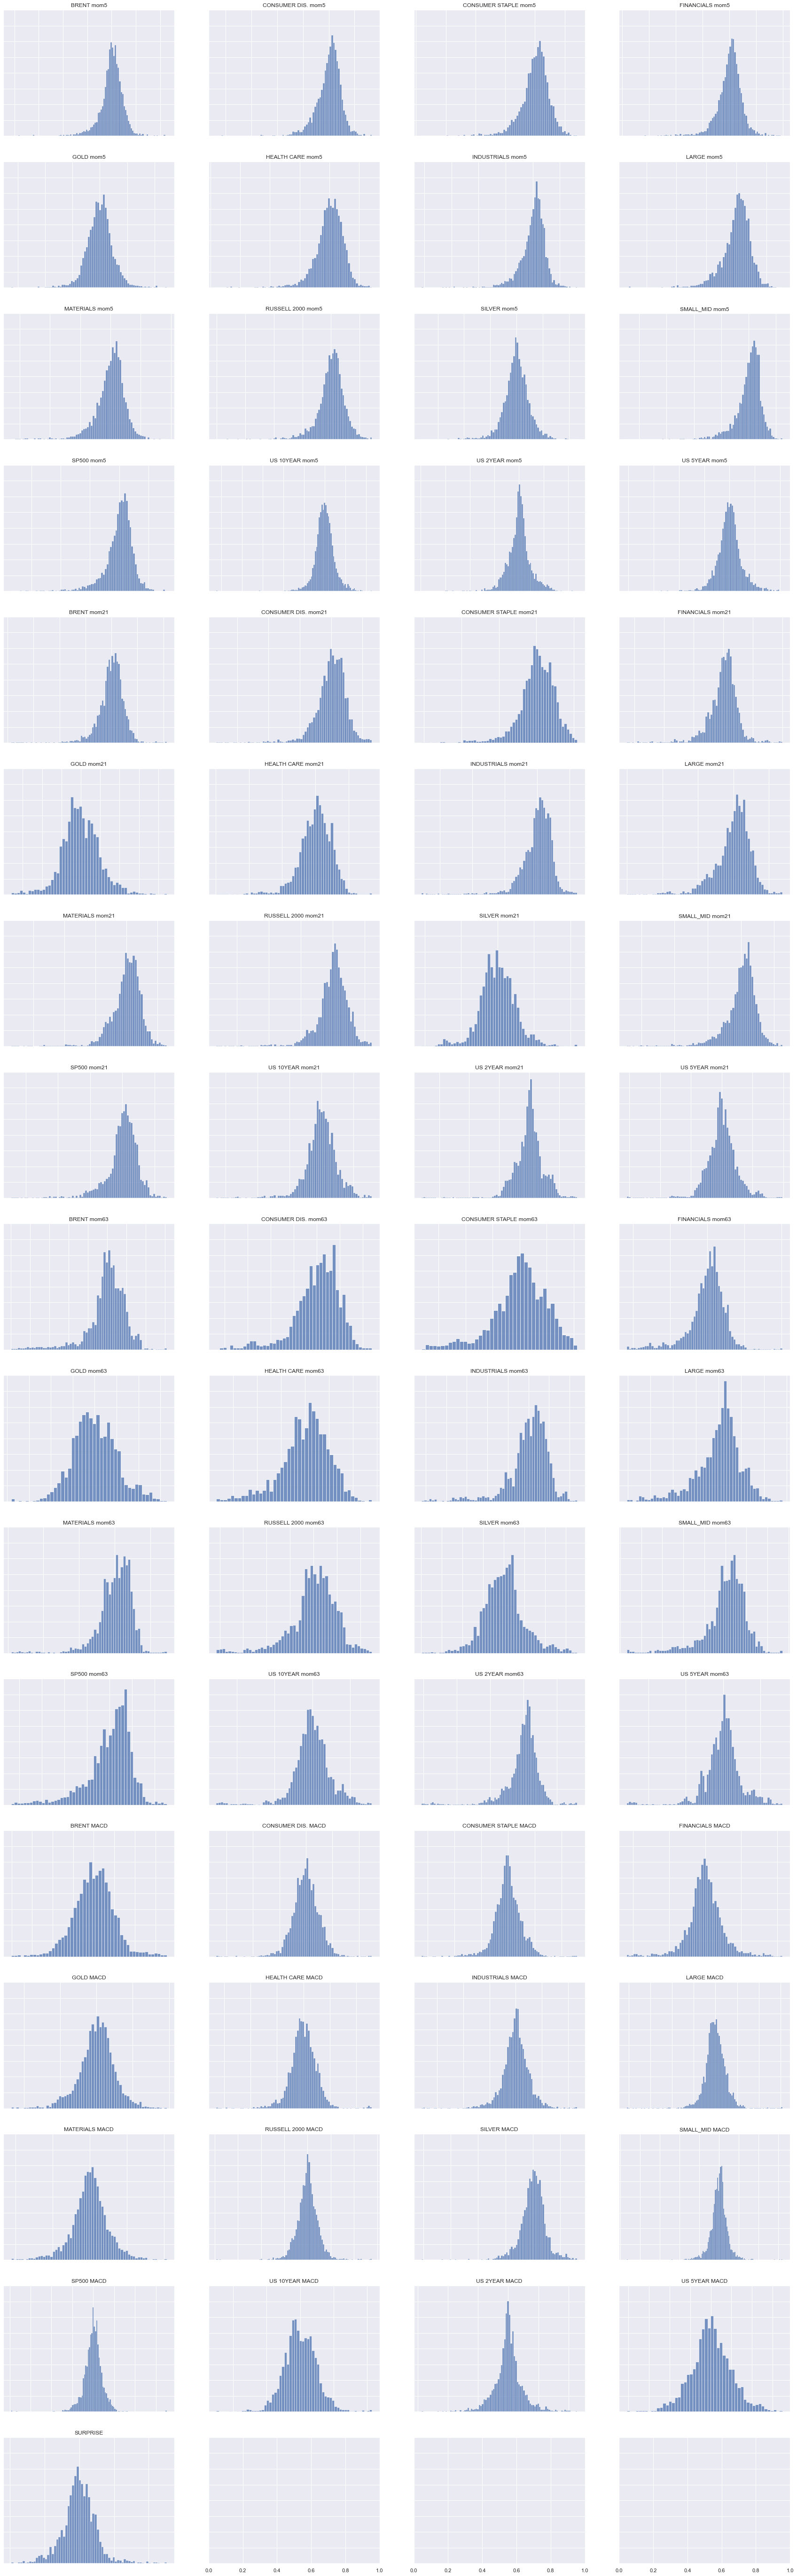

In [51]:
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(30, 100), sharey=True)
axs = axs.ravel()
for i, feature in enumerate(features):
    data = features[feature]
    data = (data - data.mean()) / data.std()
    sns.histplot(ax=axs[i], data=data)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(which='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature)

vol_ads = []
for period in range(5, 252, 2):
    vol_ads.append(adfuller(target_prices.SMALL.rolling(2).apply(lambda x: np.log(x[-1] / x[0])).rolling(period).std().dropna())[0])
plt.plot(range(5, 252, 2), vol_ads)
plt.show()

vol_ads = []
for period in range(21, 252, 2):
    vol_ads.append(adfuller(target_prices.SMALL.pct_change().rolling(period).corr(target_prices.LARGE.pct_change()).dropna())[0])
plt.plot(range(21, 252, 2), vol_ads)
plt.show()

df_features_corr = pd.DataFrame(index=target_prices.columns, columns=raw_features.columns)
for feature in raw_features.columns:
    for target in target_prices.columns:
        exog = raw_features[feature].pct_change().dropna()
        endog = target_prices[target].pct_change().reindex(exog.index)
        df_features_corr.at[target, feature] = exog.corr(endog)

print('Returns correlation between features and target variables')
display(df_features_corr.astype(float).round(2))

In [52]:
daily_forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5).reindex(features.index)

df_features_beta = pd.DataFrame(index=target_prices.columns, columns=features.columns)
df_features_stat = pd.DataFrame(index=target_prices.columns, columns=features.columns)

for feature in features:
    for target in daily_forward_weekly_returns:
        
        X = features[feature].iloc[:-5].dropna()
        y = daily_forward_weekly_returns[target].reindex(X.index)
        # X = sm.add_constant(X)
        model = sm.OLS(y, X, missing='raise')
        results = model.fit()
        
        df_features_stat.at[target, feature] = results.pvalues.values
        df_features_stat = df_features_stat.astype(float)
        
        df_features_beta.at[target, feature] = results.params.values
        df_features_beta = df_features_stat.astype(float)
        
print('Simple Linear Regression')
display(df_features_beta[np.abs(df_features_beta) > 0.01].round(4))
display(df_features_stat[df_features_stat < 0.05].round(4))

Simple Linear Regression


,BRENT mom5,CONSUMER DIS. mom5,CONSUMER STAPLE mom5,FINANCIALS mom5,GOLD mom5,HEALTH CARE mom5,INDUSTRIALS mom5,LARGE mom5,MATERIALS mom5,RUSSELL 2000 mom5,SILVER mom5,SMALL_MID mom5,SP500 mom5,US 10YEAR mom5,US 2YEAR mom5,US 5YEAR mom5,BRENT mom21,CONSUMER DIS. mom21,CONSUMER STAPLE mom21,FINANCIALS mom21,GOLD mom21,HEALTH CARE mom21,INDUSTRIALS mom21,LARGE mom21,MATERIALS mom21,RUSSELL 2000 mom21,SILVER mom21,SMALL_MID mom21,SP500 mom21,US 10YEAR mom21,US 2YEAR mom21,US 5YEAR mom21,BRENT mom63,CONSUMER DIS. mom63,CONSUMER STAPLE mom63,FINANCIALS mom63,GOLD mom63,HEALTH CARE mom63,INDUSTRIALS mom63,LARGE mom63,MATERIALS mom63,RUSSELL 2000 mom63,SILVER mom63,SMALL_MID mom63,SP500 mom63,US 10YEAR mom63,US 2YEAR mom63,US 5YEAR mom63,BRENT MACD,CONSUMER DIS. MACD,CONSUMER STAPLE MACD,FINANCIALS MACD,GOLD MACD,HEALTH CARE MACD,INDUSTRIALS MACD,LARGE MACD,MATERIALS MACD,RUSSELL 2000 MACD,SILVER MACD,SMALL_MID MACD,SP500 MACD,US 10YEAR MACD,US 2YEAR MACD,US 5YEAR MACD,SURPRISE
SMALL_MID,0.5528,0.4772,0.0471,0.6057,NaN,0.1395,0.7072,0.3895,0.1979,0.3951,NaN,0.3902,0.1387,NaN,NaN,0.0197,0.3475,0.0796,0.0740,0.0155,NaN,0.8339,0.0488,NaN,NaN,0.953,0.067,0.2195,0.5424,0.0859,NaN,0.0469,0.5368,0.1785,0.4840,0.5224,0.3361,0.0243,0.2177,0.9879,NaN,0.2770,NaN,0.2107,0.6266,0.9462,0.3663,0.9067,0.3924,0.8686,0.0404,0.0156,NaN,0.6459,0.4126,NaN,0.1558,0.5925,NaN,0.4555,0.0994,0.7898,0.0121,0.4498,NaN
LARGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5392,0.9451,0.4403,0.5517,NaN,0.0207,0.1414,NaN,NaN,NaN,0.0201,0.0464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1841,0.3351,0.2562,0.5550,0.1709,NaN,0.2369,0.1362,0.5856,0.0315,0.7195,0.5540,0.0576,0.8589,0.7289,0.7013,NaN,NaN,0.1782,0.2283,NaN,NaN,NaN,0.1711,NaN,NaN,NaN,NaN,0.0202,NaN,0.3220,0.0122,0.0224


,BRENT mom5,CONSUMER DIS. mom5,CONSUMER STAPLE mom5,FINANCIALS mom5,GOLD mom5,HEALTH CARE mom5,INDUSTRIALS mom5,LARGE mom5,MATERIALS mom5,RUSSELL 2000 mom5,SILVER mom5,SMALL_MID mom5,SP500 mom5,US 10YEAR mom5,US 2YEAR mom5,US 5YEAR mom5,BRENT mom21,CONSUMER DIS. mom21,CONSUMER STAPLE mom21,FINANCIALS mom21,GOLD mom21,HEALTH CARE mom21,INDUSTRIALS mom21,LARGE mom21,MATERIALS mom21,RUSSELL 2000 mom21,SILVER mom21,SMALL_MID mom21,SP500 mom21,US 10YEAR mom21,US 2YEAR mom21,US 5YEAR mom21,BRENT mom63,CONSUMER DIS. mom63,CONSUMER STAPLE mom63,FINANCIALS mom63,GOLD mom63,HEALTH CARE mom63,INDUSTRIALS mom63,LARGE mom63,MATERIALS mom63,RUSSELL 2000 mom63,SILVER mom63,SMALL_MID mom63,SP500 mom63,US 10YEAR mom63,US 2YEAR mom63,US 5YEAR mom63,BRENT MACD,CONSUMER DIS. MACD,CONSUMER STAPLE MACD,FINANCIALS MACD,GOLD MACD,HEALTH CARE MACD,INDUSTRIALS MACD,LARGE MACD,MATERIALS MACD,RUSSELL 2000 MACD,SILVER MACD,SMALL_MID MACD,SP500 MACD,US 10YEAR MACD,US 2YEAR MACD,US 5YEAR MACD,SURPRISE
SMALL_MID,NaN,NaN,0.0471,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0036,0.0069,0.0197,NaN,NaN,NaN,0.0155,0.0,NaN,0.0488,0.0062,0.0005,NaN,NaN,NaN,NaN,NaN,0.0062,0.0469,NaN,NaN,NaN,NaN,NaN,0.0243,NaN,NaN,0.0023,NaN,0.0048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0404,0.0156,0.0,NaN,NaN,0.007,NaN,NaN,0.0,NaN,NaN,NaN,0.0121,NaN,0.0006
LARGE,0.01,0.0004,0.0006,0.0014,0.0,0.0,0.0,0.0,0.0001,0.0,0.0,0.0001,0.0,NaN,NaN,NaN,NaN,0.008,0.0207,NaN,0.0,0.0,0.0043,0.0201,0.0464,0.0001,0.0001,0.001,0.0002,0.0004,0.0000,0.0003,NaN,NaN,NaN,NaN,NaN,0.0043,NaN,NaN,NaN,0.0315,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0017,NaN,NaN,0.0,0.0012,0.0019,NaN,0.0029,0.001,0.0,0.0071,0.0202,0.0021,NaN,0.0122,0.0224


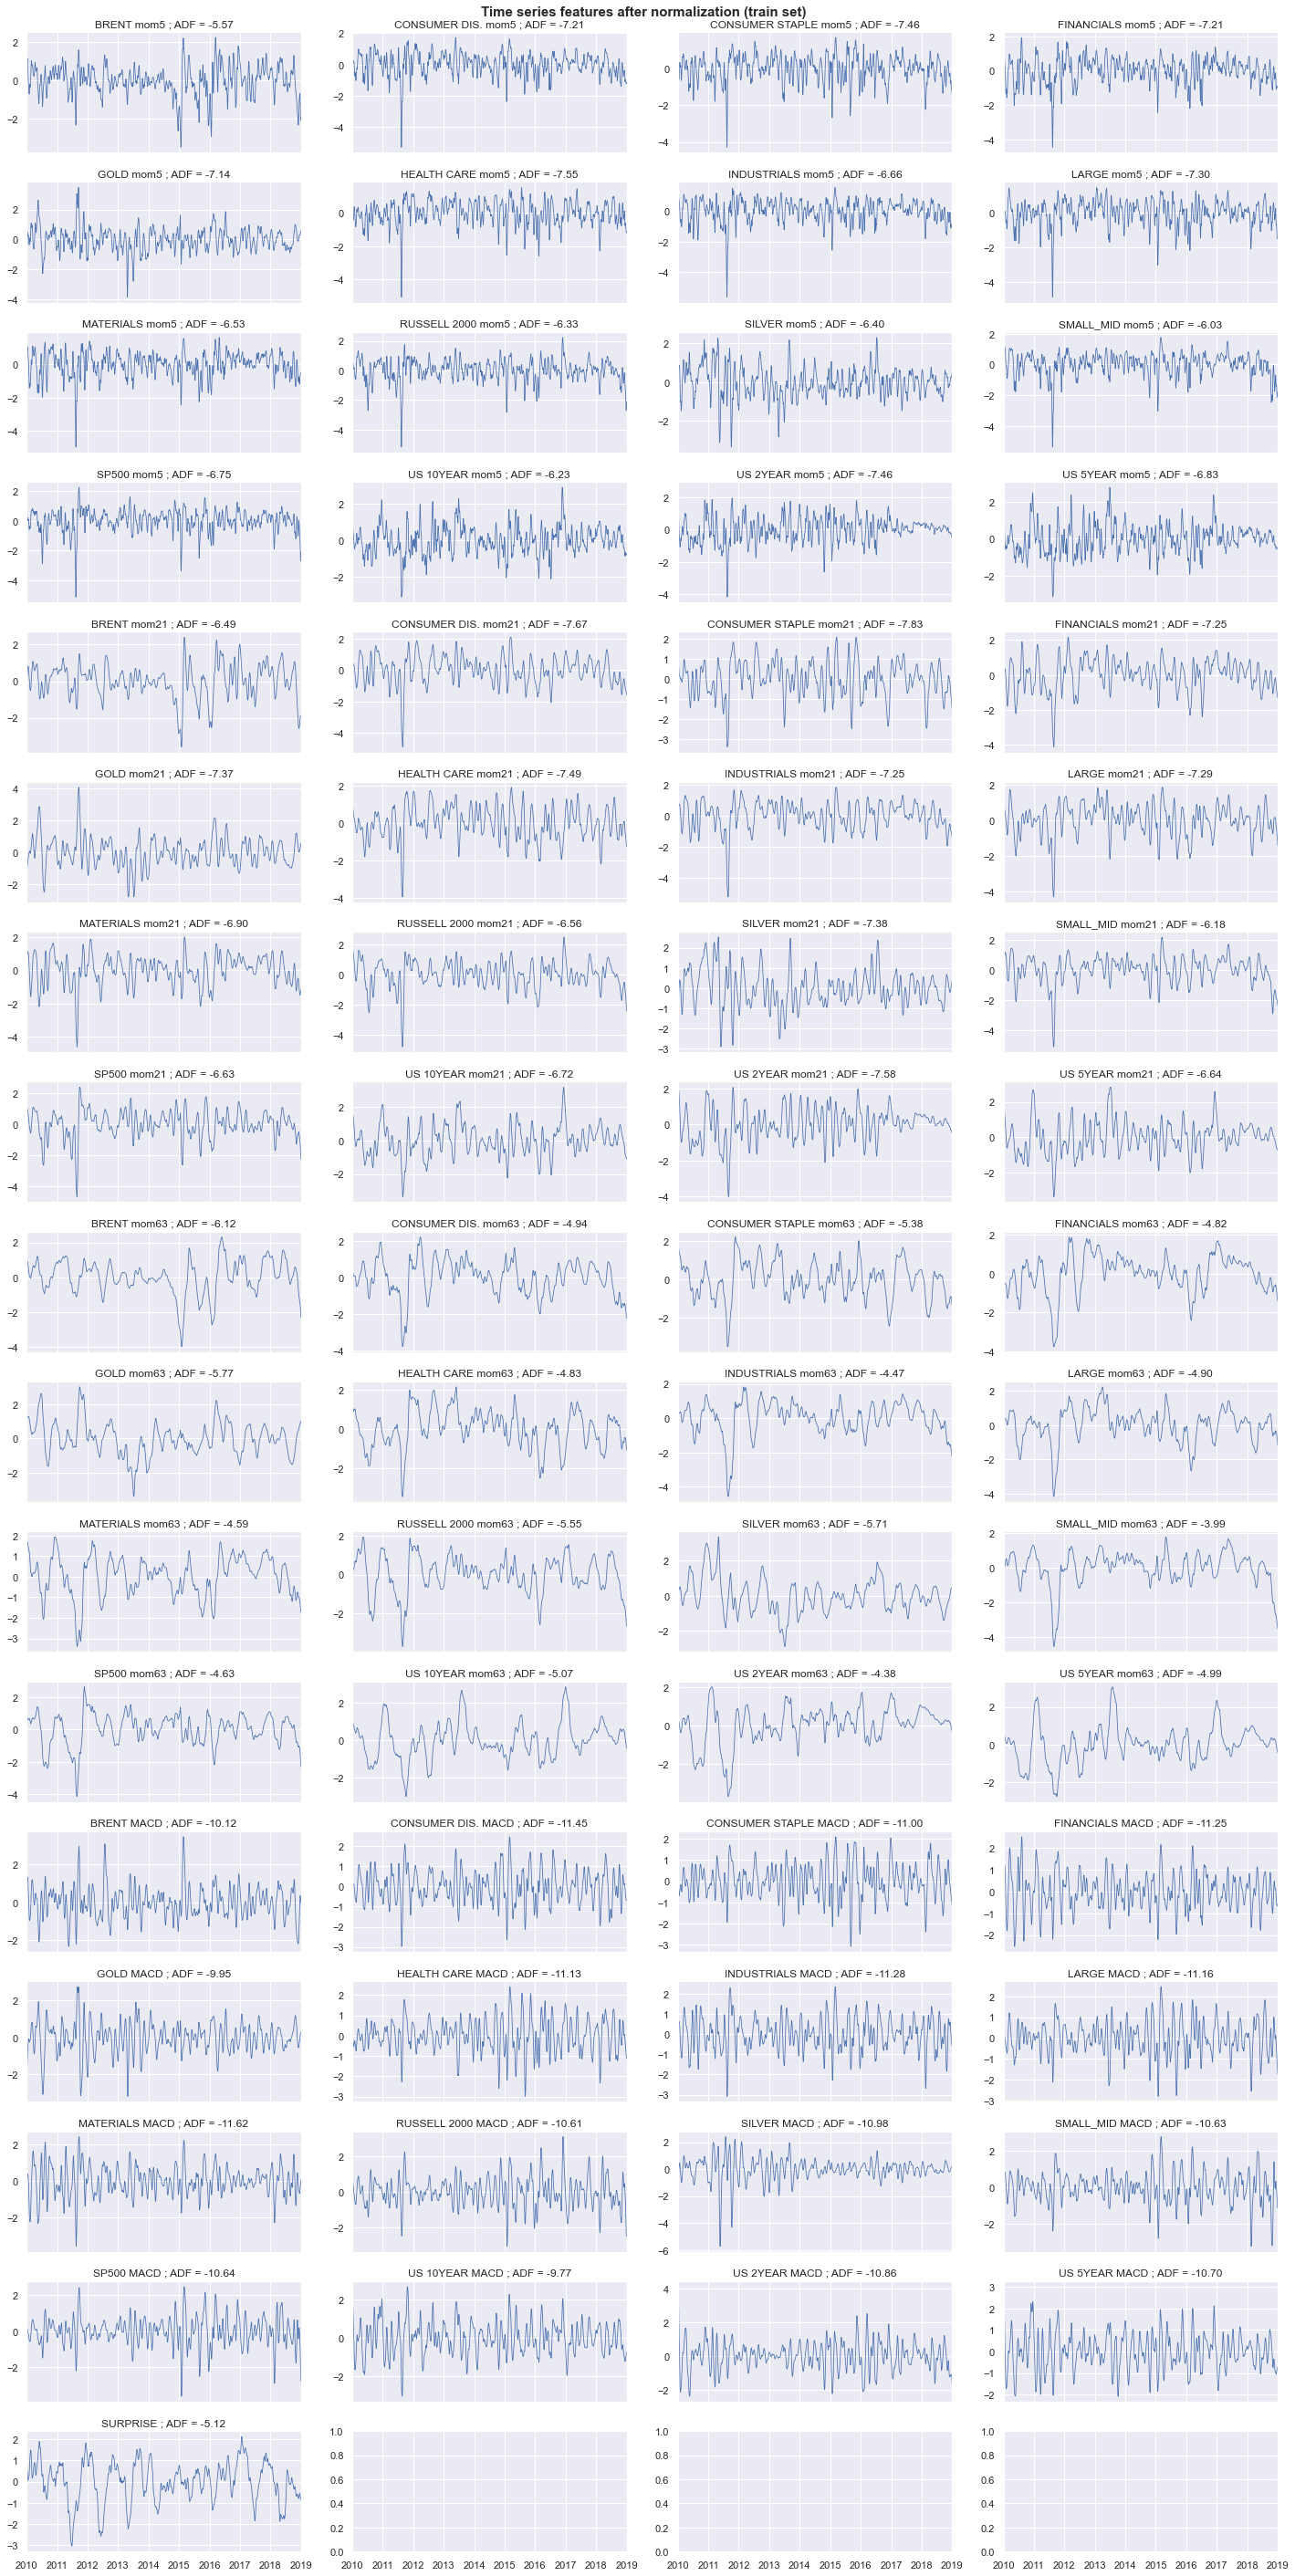

In [55]:
data_plot = features.loc['2010-01-01':'2019-01-01']
data_plot = (data_plot - data_plot.mean()) / data_plot.std()
data_plot = data_plot.ewm(5).mean()

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(20, 40), sharex=True)
axs = axs.ravel()

for i, col in enumerate(data_plot.columns):
    
    ads = adfuller(data_plot[col].values)[0]
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {ads:.2f}')

plt.suptitle('Time series features after normalization (train set)', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.97)
plt.show()

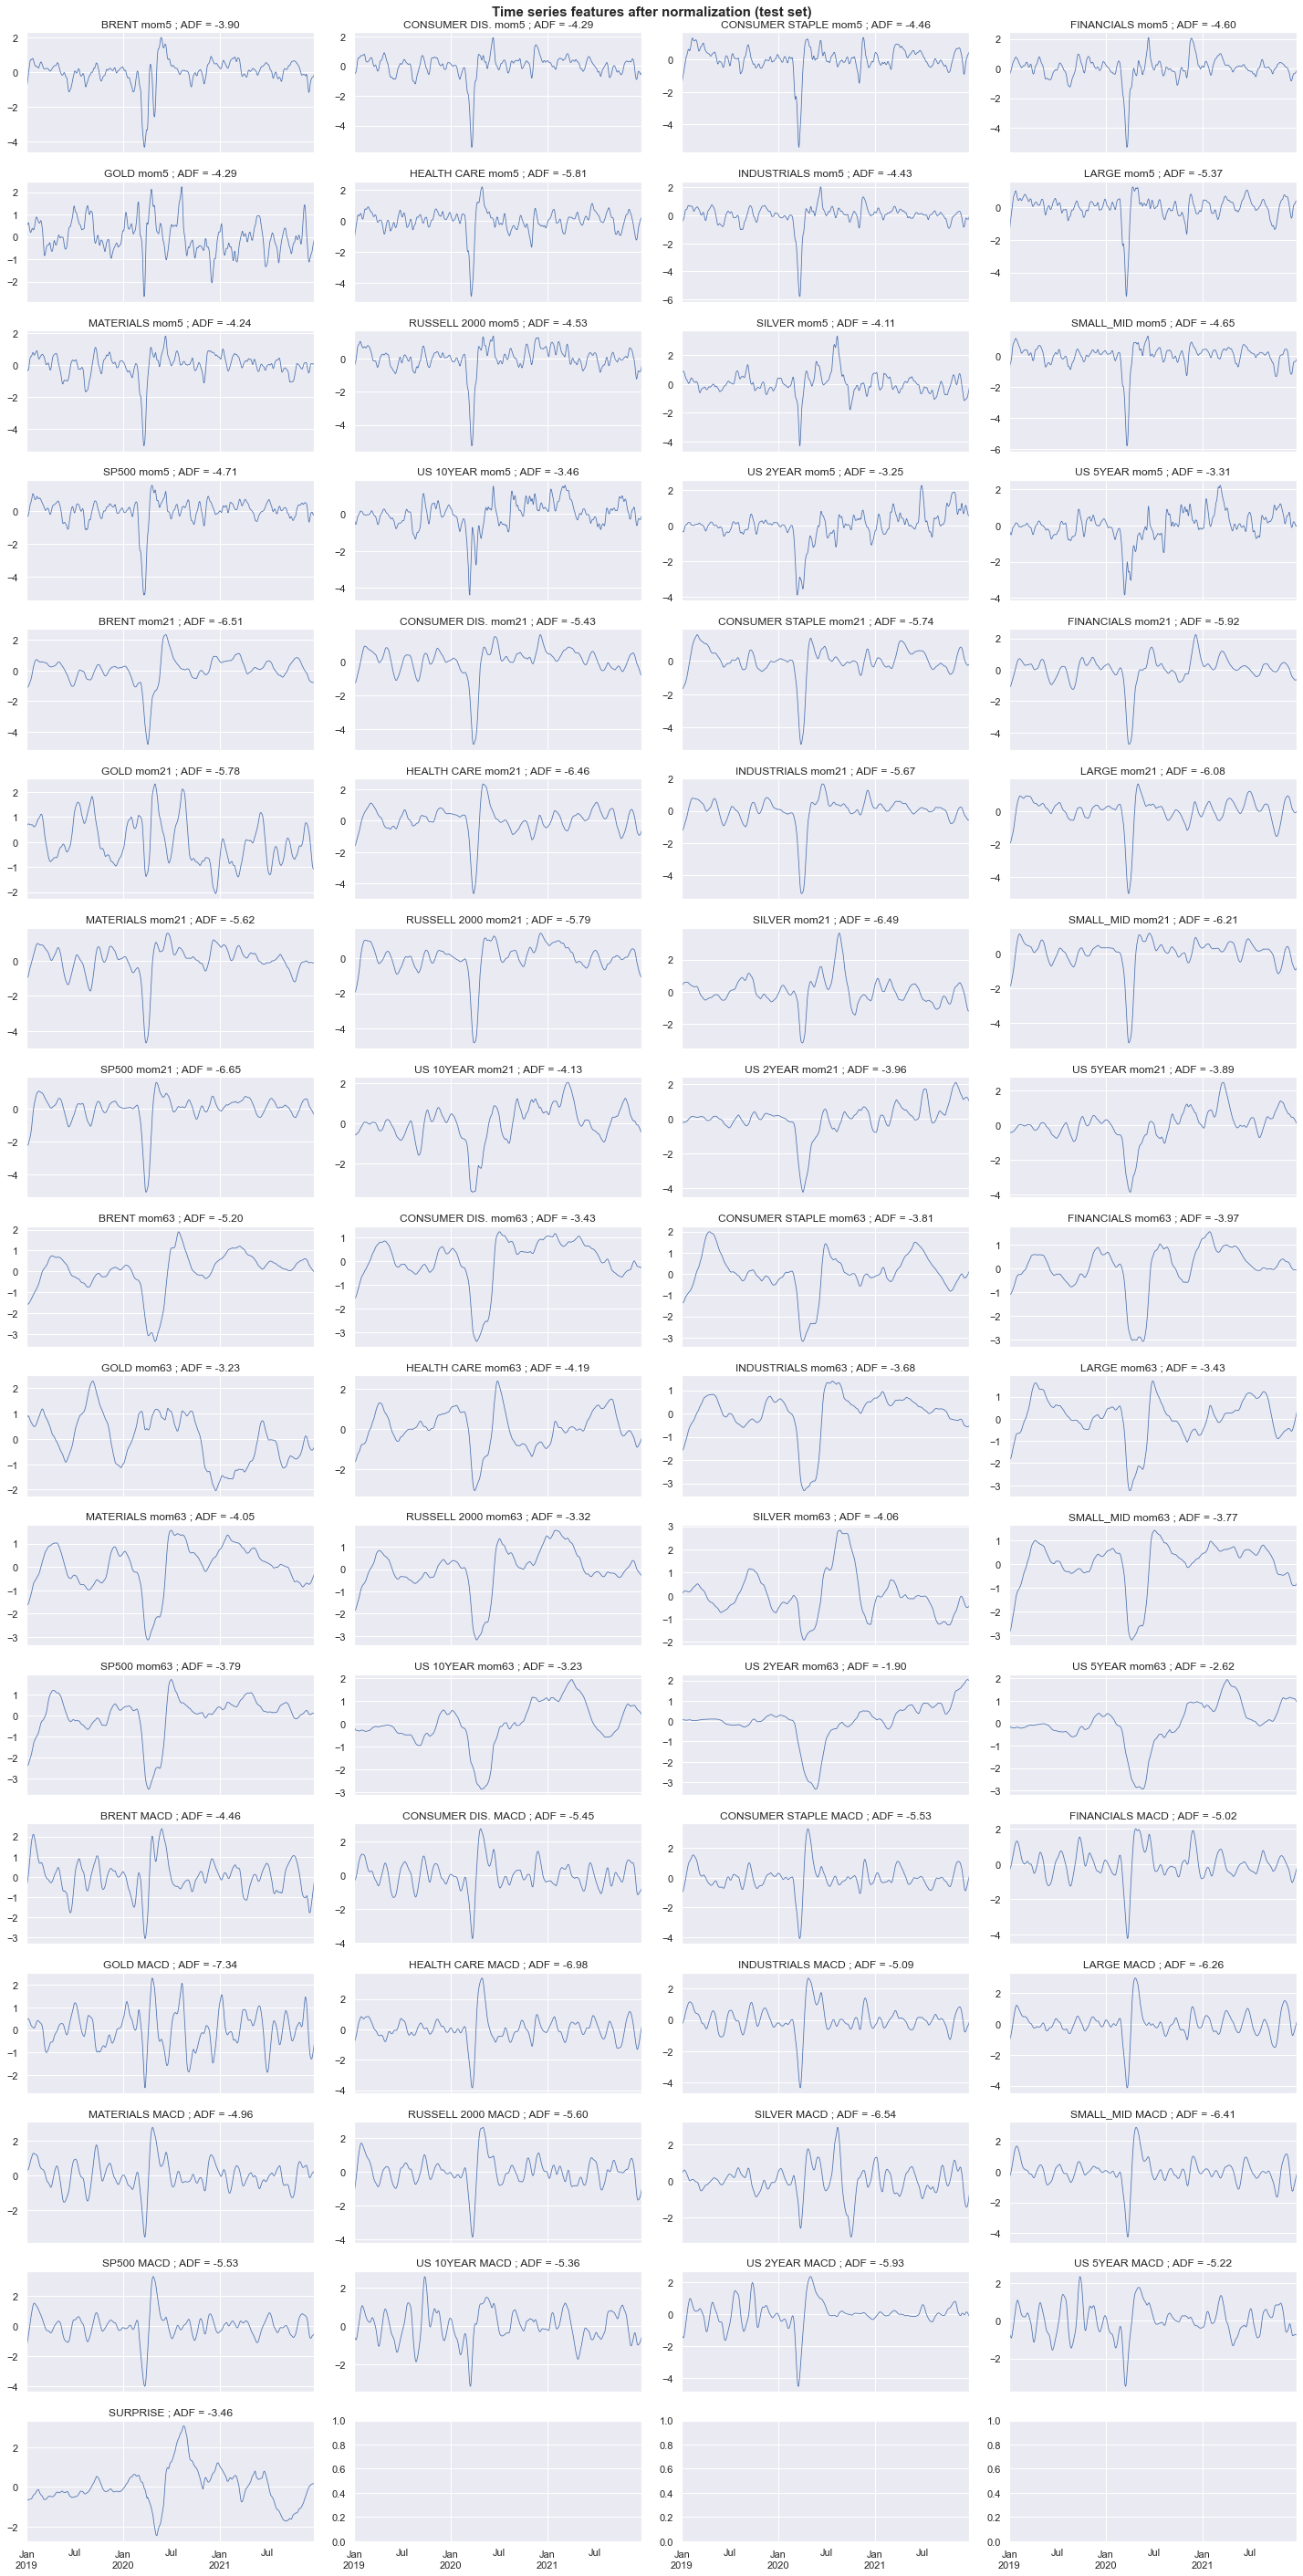

In [56]:
data_plot = features.loc['2019-01-01':]
data_plot = (data_plot - data_plot.mean()) / data_plot.std()
data_plot = data_plot.ewm(5).mean()

number_feature = len(data_plot.columns)
fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(20, 40), sharex=True)
axs = axs.ravel()

for i, col in enumerate(data_plot.columns):
    
    ads = adfuller(data_plot[col].values)[0]
    data_plot[col].plot(ax=axs[i], lw=0.8)
    axs[i].set_title(col + f' ; ADF = {ads:.2f}')

plt.suptitle('Time series features after normalization (test set)', fontsize=15, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.97)
plt.show()

corr = data_plot.corr().abs().round(2)

fig, ax = plt.subplots(figsize=(20, 20))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=False, cmap='Reds', cbar=False, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=8, labelbottom=False, labeltop=False, labelleft=False, length=0)
plt.show()